# Prediction of Fuel Consumption


Firstly, we will connect to our drive where  dataset is located.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##1.Import the libraries


> Here is the libraries that we will use in project



In [2]:
import pandas as pd # for data manipulation
import seaborn as sns # supports matplotlib in rendering good and beautiful charts.
import numpy as np # for working with arrays
import matplotlib.pyplot as plt # for visualization purposes

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler # for data preprocessing and scaling
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # linear regression models
from sklearn.model_selection import train_test_split, GridSearchCV # for data splitting and parameter tuning
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# warning 
import warnings
warnings.filterwarnings('ignore')

##2.Import Dataset


> In our dataset includes 9 features(coloumns). These are :


1.   MPG
2.   Cylinders
3.   Displacement
4.   Horsepower
5.   Weight
6.   Acceleration
7.   Model Year
8.   Origin (1-America, 2-Europe, 3-Japan)
9.   Car Name



> But in dataset there is no column names, so firstly we will label the columns.



> Then, we will read the data file from drive. 










In [3]:
# We will not use car name attribute because it is not necessary for predicting MPG!
column_name = ["MPG", "Cylinders", "Displacement","Horsepower","Weight","Acceleration","Model Year", "Origin"]

data = pd.read_csv("/content/gdrive/MyDrive/Prediction of Fuel Consumption/auto-mpg.data", names = column_name, na_values = "?", comment = "\t",sep = " ", skipinitialspace = True)

# to be easy to understand we rename MPG to target
data = data.rename(columns = {"MPG":"TARGET"})


We will look at first 5 values and  shape of the data

In [4]:
print(data.head())
print("Data shape: ",data.shape)

   TARGET  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
0    18.0          8         307.0  ...          12.0          70       1
1    15.0          8         350.0  ...          11.5          70       1
2    18.0          8         318.0  ...          11.0          70       1
3    16.0          8         304.0  ...          12.0          70       1
4    17.0          8         302.0  ...          10.5          70       1

[5 rows x 8 columns]
Data shape:  (398, 8)


##3.Missing Values 



> We can detect the data has null values or not 



In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TARGET        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [6]:
describe = data.describe()

In [7]:
# How much  missing value has each column?

print(data.isna().sum())


TARGET          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


We can see the 'Horsepower' column has 6 missing values







In [8]:
# Take the mean of horsepower and fill it into the null values

data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())

# Check missing values again

print(data.isna().sum())


TARGET          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


##4.Exploratory Data Analysis



> Firstly, we should look at correlation between features.


> We can see the negative and positive correlation between features. Negative correlation means that they have inverse proportion, positive correlation means direct proportion





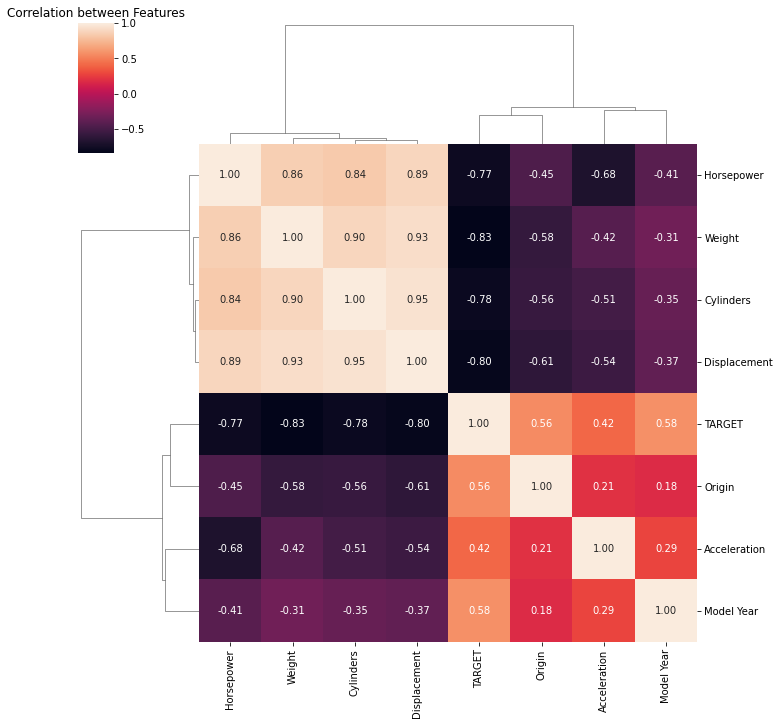

In [9]:
# EDA (Exploratory Data Analysis)

corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f" )
plt.title("Correlation between Features")
plt.show()

> We will put one filter in order to see features above 0.75.

> The reason  we do this is to make it easier to see in the pairplot and make the correlation matrix smaller.



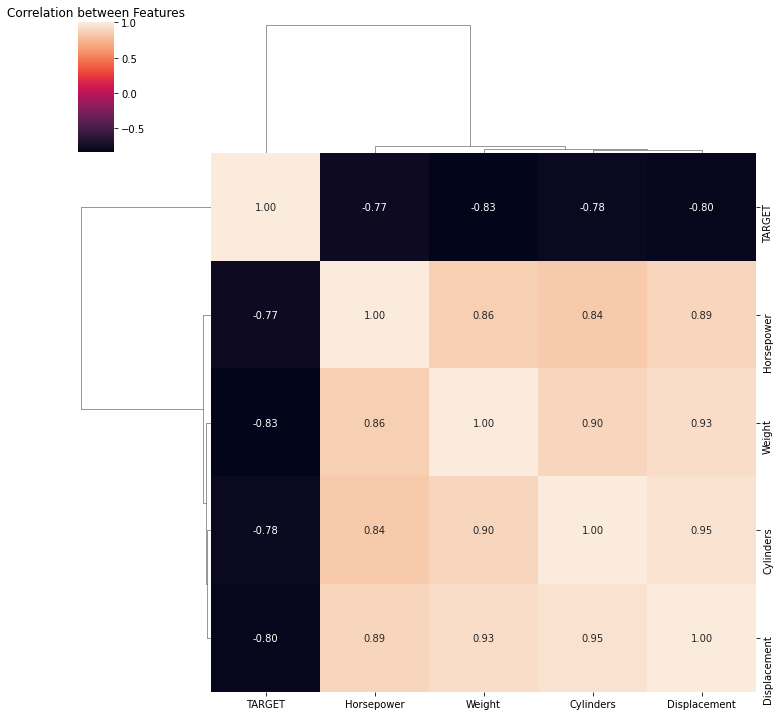

In [10]:

threshold = 0.75
filter = np.abs(corr_matrix["TARGET"]) > threshold # take the thresholds related to dependence variable(Target)
corr_features = corr_matrix.columns[filter].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f" )
plt.title("Correlation between Features")
plt.show()

> With pairplot we can see the whole picture that relationship between them



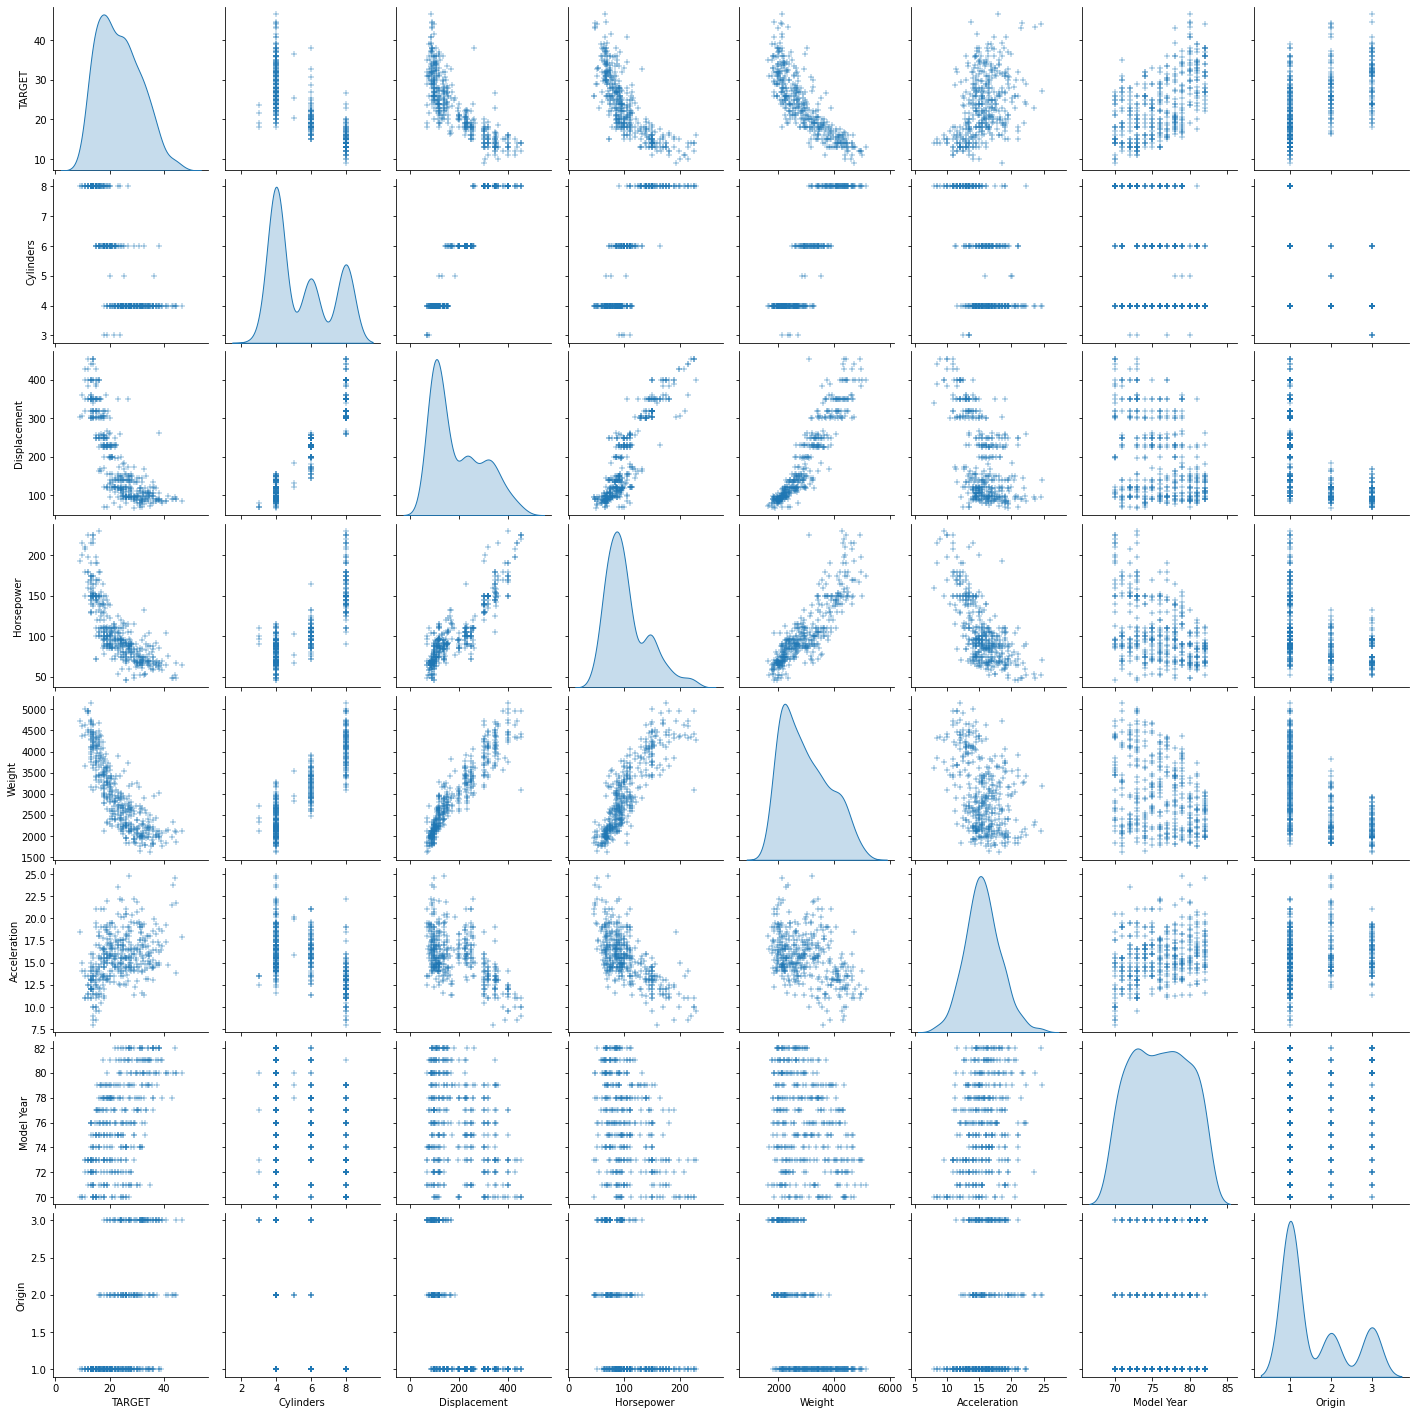

In [11]:
sns.pairplot(data, diag_kind = "kde", markers = "+")
plt.show()

> Looking at their relationship with target in the graphs above, we can see that *'Cylinders'* and *'Origin'* columns are categorical data.



4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64


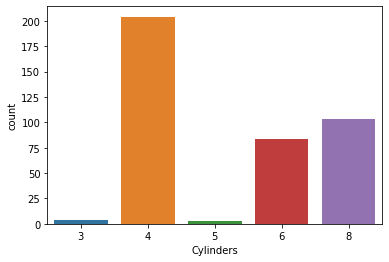

In [12]:

plt.figure()
sns.countplot(data["Cylinders"])
print(data["Cylinders"].value_counts())

1    249
3     79
2     70
Name: Origin, dtype: int64


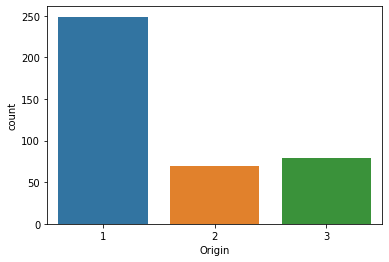

In [13]:
plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())



##5.Outliers



> We can see there is outliers or not with using boxplot



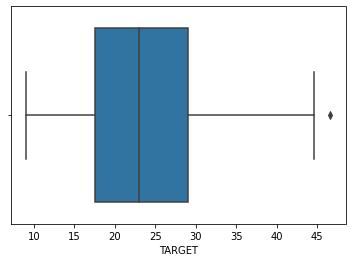

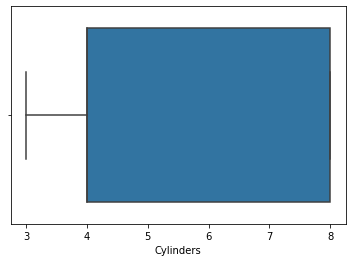

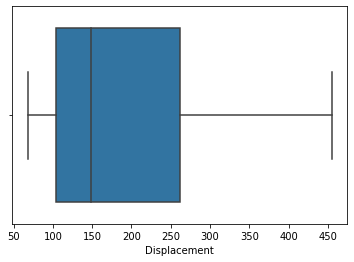

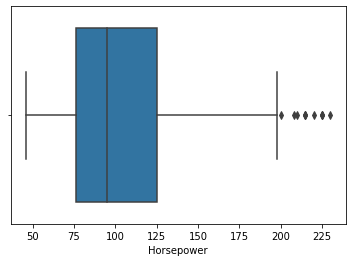

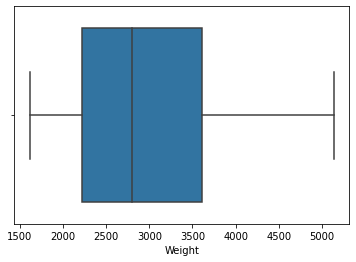

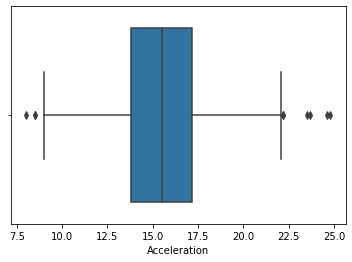

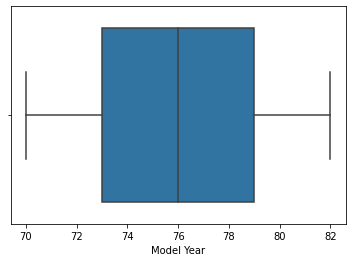

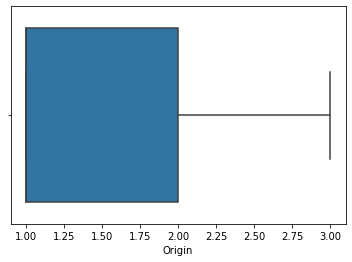

In [14]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")
    



> As we can see, 'Horsepower' and 'Acceleration' columns has outliers.


> So we should drop the outliers for well-working predicting model





In [15]:

thr = 2

horsepower_desc = describe["Horsepower"]

q3_hp = horsepower_desc[6] # value of 75%
q1_hp = horsepower_desc[4] # value of 25%
IQR_hp = q3_hp - q1_hp

top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp

filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp

filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]  # remove Horsepower outliers

In [16]:
print(horsepower_desc)

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64


In [17]:
acceleration_desc = describe["Acceleration"]

q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc # q3 - q1

top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc

filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top= data["Acceleration"] < top_limit_acc

filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc] # remove Acceleration  outliers


##6.Feature Extraction

#Skewness

mu : 23.472405063291134, sigma : 7.756119546409932


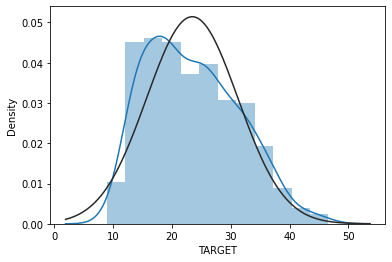

In [18]:

# Target is  dependent variable

sns.distplot(data.TARGET, fit = norm)

(mu, sigma) = norm.fit(data["TARGET"])

print("mu : {}, sigma : {}".format(mu, sigma))

As we can see, we have Right-Skewed

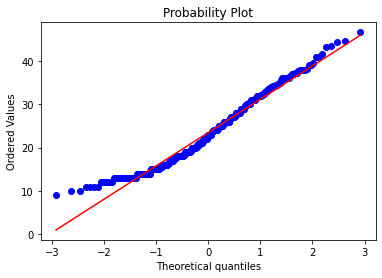

In [19]:
# qq plot (quantile quantile plot)

plt.figure()
stats.probplot(data["TARGET"], plot = plt)
plt.show()


Our data should be on the red line

mu : 3.146474056830183, sigma : 0.3227569103044822


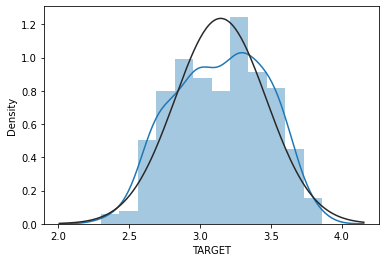

In [20]:

data["TARGET"] = np.log1p(data["TARGET"])# we do the logarithm transform to reduce the skewness value 

plt.figure()
sns.distplot(data.TARGET, fit = norm)

(mu, sigma) = norm.fit(data["TARGET"])

print("mu : {}, sigma : {}".format(mu, sigma))

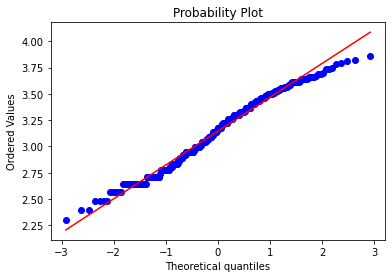

In [21]:
plt.figure()
stats.probplot(data["TARGET"], plot = plt)
plt.show()

In [22]:
# feature - independent variable

skewed_feats = data.apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["Skewed"])


**One Hot Encoding**

In [23]:
#become cathegorical 
data["Cylinders"] = data["Cylinders"].astype(str)
data["Origin"] = data["Origin"].astype(str)

data = pd.get_dummies(data)


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 397
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TARGET        395 non-null    float64
 1   Displacement  395 non-null    float64
 2   Horsepower    395 non-null    float64
 3   Weight        395 non-null    float64
 4   Acceleration  395 non-null    float64
 5   Model Year    395 non-null    int64  
 6   Cylinders_3   395 non-null    uint8  
 7   Cylinders_4   395 non-null    uint8  
 8   Cylinders_5   395 non-null    uint8  
 9   Cylinders_6   395 non-null    uint8  
 10  Cylinders_8   395 non-null    uint8  
 11  Origin_1      395 non-null    uint8  
 12  Origin_2      395 non-null    uint8  
 13  Origin_3      395 non-null    uint8  
dtypes: float64(5), int64(1), uint8(8)
memory usage: 24.7 KB


##7.Split and Standardization

In [25]:
# Split

x = data.drop(["TARGET"], axis = 1)
y = data.TARGET

test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)
 

In [26]:
# Standardization

scaler = StandardScaler() # RobustScaler or StandardScaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


##Regression Models

In [27]:

# linear regression

lr = LinearRegression()
lr.fit(X_train, Y_train)

print("LR Coef : ", lr.coef_)

y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)

print("Linear Regression MSE : ", mse)
print("Test Accuracy: {}" .format(lr.score(X_test, Y_test)))

LR Coef :  [ 4.33539196e-02 -7.00351554e-02 -1.74807489e-01 -1.45415203e-02
  9.99434620e-02 -2.27927155e-02  3.74789759e-02  1.12061085e-02
 -2.24108324e-02 -1.84760400e-02 -1.72042847e-02  1.38324896e-04
  2.05067107e-02]
Linear Regression MSE :  0.013399767146757242
Test Accuracy: 0.8448968040442394


In [28]:
# Ridge Regression (L2) - minimazing (least-squared error + λ*(slope)^2) --> advantage - prevents from overfitting

ridge = Ridge(random_state = 42, max_iter = 10000)

alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{"alpha" : alphas}]

n_folds = 5


In [29]:
#classifier
clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]


In [30]:
print("Ridge Coef : ", clf.best_estimator_.coef_)
ridge = clf.best_estimator_
print("Ridge Best Estimator : ", ridge)

y_predicted_dummy_rd = clf.predict(X_test)

mse = mean_squared_error(Y_test, y_predicted_dummy_rd)
print("Ridge MSE : ", mse)
print("Test Accuracy: {}" .format(ridge.score(X_test, Y_test)))


Ridge Coef :  [ 4.06552738e-02 -7.00085623e-02 -1.72917369e-01 -1.48054915e-02
  9.97118288e-02 -2.30116500e-02  3.72295686e-02  1.11324719e-02
 -2.23907013e-02 -1.81369765e-02 -1.70931886e-02 -1.56489559e-05
  2.05155214e-02]
Ridge Best Estimator :  Ridge(alpha=0.31622776601683794, copy_X=True, fit_intercept=True,
      max_iter=10000, normalize=False, random_state=42, solver='auto',
      tol=0.001)
Ridge MSE :  0.013421245209101295
Test Accuracy: 0.8446481940440793


In [31]:
# Lasso Regression (L1) - minimazing (least-squared error * λ * slope) --> advantage - redundant coef values are assigned 0


lasso = Lasso(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

In [32]:
clf = GridSearchCV(lasso, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error",  refit = True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]


In [33]:
print("Lasso Coef : ", clf.best_estimator_.coef_)
lasso = clf.best_estimator_

y_predicted_dummy_lss = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy_lss)
print("Lasso MSE: ",mse) 
print("Test Accuracy: {}" .format(lasso.score(X_test, Y_test)))


Lasso Coef :  [ 0.03139269 -0.06659594 -0.17176    -0.01408541  0.09942275 -0.01962127
  0.0527184   0.01407385 -0.0072404  -0.         -0.01585649  0.
  0.02037116]
Lasso MSE:  0.013403675670455173
Test Accuracy: 0.844851562622476


In [34]:
# ElasticNet - minimazing(least-squared error + λ1* (slope)^2 +  λ2 * slope ) Like mixed version of lasso and ridge


parametersGrid = {"alpha" : alphas,
                  "l1_ratio" : np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state = 42, max_iter = 10000)
clf = GridSearchCV(eNet, parametersGrid, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)

eNet = clf.best_estimator_

print("ElasticNet Coef : ", clf.best_estimator_.coef_)
print("ElasticNet Best Estimator : ", clf.best_estimator_)


y_predicted_dummy_eNet = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy_eNet)
print("ElasticNet MSE : ", mse)
print("Test Accuracy: {}" .format(eNet.score(X_test, Y_test)))

ElasticNet Coef :  [ 0.02440704 -0.06980685 -0.16082902 -0.01634179  0.09817019 -0.02423724
  0.0360529   0.01068281 -0.02229063 -0.01647006 -0.01646491 -0.00095338
  0.02062713]
ElasticNet Best Estimator :  ElasticNet(alpha=0.008531678524172814, copy_X=True, fit_intercept=True,
           l1_ratio=0.0, max_iter=10000, normalize=False, positive=False,
           precompute=False, random_state=42, selection='cyclic', tol=0.0001,
           warm_start=False)
ElasticNet MSE :  0.013576740895132203
Test Accuracy: 0.8428483211360965


In [35]:
# XGBoost is an algorithm that  designed for big, complex data sets.

parametersGrid = {"nthread" : [4], #when use hyperthread, xgboost may become slower
              "objective" : ["reg:linear"],
              "learning_rate" : [.03, 0.05, .07], 
              "max_depth" : [5, 6, 7],
              "min_child_weight" : [4],
              "silent" : [1],
              "subsample" : [0.7],
              "colsample_bytree" : [0.7],
              "n_estimators" : [500, 1000] }

model_xgb = xgb.XGBRegressor()

In [36]:
clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring = "neg_mean_squared_error", refit = True, n_jobs = 5, verbose = True)

clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy_xgb = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy_xgb)
print("XGBRegressor MSE: ", mse)
print("Test Accuracy: {}" .format(model_xgb.score(X_test, Y_test)))


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:   53.7s finished


XGBRegressor MSE:  0.008169698221682037
Test Accuracy: 0.905435199709151


##Averaging Models

In [37]:
class AveragingModels():
    
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis = 1)  


In [40]:
averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)


y_predicted_dummy_avg = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy_avg)
print("Averaged Models MSE: ", mse)


Averaged Models MSE:  0.009725210953111862


We have to use ***np.expm1*** transformation because we did ***np.log1p*** transformation before.

In [41]:
y_test_value = np.expm1(Y_test) 
predicted_value = np.expm1(y_predicted_dummy_xgb)


In [42]:
print(predicted_value)

[19.695387  27.232092  20.34813   27.422697  27.869938  14.808709
 12.376353  28.26524   30.078894  27.97346   13.222893  20.912508
 41.501682  30.005098  19.92259   13.9547615 18.25856   26.513218
 38.300285  28.500572  18.495453  27.93801   24.751244  15.900948
 25.869442  21.047216  23.594257  20.364016  18.388912  21.708797
 36.188026  37.8761    16.693563  30.991526  11.109976  25.368574
 13.963878  24.113052  14.30536   10.70858   15.39324   25.597229
 37.625015  28.399506  13.819546  13.497078  21.70018   26.861298
 22.441683  29.676064  14.268155  28.098671  23.541405  35.703587
 28.274117  16.255768  18.917873  19.395681  24.751556  24.975239
 11.64909   19.6264    13.428101  22.194866  28.07175   26.334576
 19.365448  25.265379  32.986244  12.890293  19.062933  26.26067
 17.652725  23.223318  21.136753  23.280056  23.42882   16.610977
 26.975079 ]
